# ANÁLISIS BICIMAD
En concreto vamos a analizar el siguiente anáisis del conjunto de datos de junio 2019, pues la empresa quería ponerse en funcionamiento en septiembre de 2019:
1. Estudio del alquiler de bicicletas en ciclos. Considerando un ciclo, un trayecto en el cual la estacion de salida y llegada es la misma.
2. Estudio de la frecuencia de los caminos. En los cuales, se interpreta que la bicicleta se ha usado para el disfrute y no para desplazarse.
3. El rango de edad de los usuarios de BICIMAD.
4. Las estaciones más y menos utilizadas.

Importamos librerias :

In [1]:
import findspark
findspark.init()
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#from pyspark.sql import SparkSession #Para crear una sesión de Spark
from pyspark.sql.types import *  
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from collections import Counter #Para contar la frecuencia de los elementos de una lista
import json # Datos en formato JSON, pues los datos de BICIMAD vienen en ese formato
#from pprint import pprint # Para imprimir de manera legible los resultados
import datetime # Para poder trabajar con fechas 
import sys
import statistics
import pandas as pd
import matplotlib.pyplot as plt

# Creamos sesión en spark

In [3]:
#spark = SparkSession.builder.getOrCreate() #Creamos la sesión
conf = SparkConf()\
        .setAppName('PracticaSpark')
sc = SparkContext(conf = conf)

# Abrimos el archivo correspondiente a junio de 2022


In [4]:
import json
with open(r"C:/Users/j4gon/Downloads/junio2019.json", encoding='latin1') as f:
    data = f.readlines()
     

rdd = sc.textFile(r"C:/Users/j4gon/Downloads/junio2019.json")

Seleccionamos los datos que vamos a utilizar:

In [5]:
def FiletoDic(line):

  data=json.loads(line)
  id_bici = data['_id']
  usuario = data['user_day_code']
  salida = data['idunplug_station']
  llegada = data['idplug_station']
  tiempo = data['travel_time']
  edad = data['ageRange']
  tipo = data['user_type']
  
  return usuario,id_bici,salida,llegada,tiempo,edad,tipo

In [6]:
rdd1 = rdd.map(FiletoDic)
rdd.map(FiletoDic).take(1)

[('e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b',
  {'$oid': '5cf83b752f3843a016be4e2f'},
  90,
  66,
  219,
  0,
  1)]

# (1) : Estudio ciclos

Procedimiento:
1. Obtenemos las estaciones de salida y llegada para cada usuario ( mediante las funciones salidas() y llegadas() ).
2. Comprobamos cuando coincide la estación de salida y de llegada de la misma bicicleta.
3. Obtenemos el tiempo medio que tardan los usuarios en realizar un ciclo.
4. Por último, dado que pueden realizar paradas intermedias, comprobamos cuantas paradas hacen los usuarios que realizan un ciclo.

In [7]:
def salidas(line):
    data    = FiletoDic(line)
    return data[0],data[2]

In [8]:
lista_salidas = rdd.map(salidas)
lista_salidas.take(10)


[('e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b', 90),
 ('8a0c4123e924a50a958f51985eb71aea750fb072438035f149283490cc6bfaf4', 71),
 ('a6a9c1f74a68496000542210abc4fc2eba79e2756ad5355a626632f7783dd418', 39),
 ('5706c0bd494acc02279d532821c9666b0e506d4f81c838ef3147b2e0abbe7156', 66),
 ('eb1b6d32bd4add5d5ff91af72a38786d61075c090383a53882f33b0801eb0079', 152),
 ('c2905f6038aa9523da6bc3222c63c2ec3269c69281bf34eac161eed1ae2ba5f4', 55),
 ('f94420744ea060ac42ef3901cb251bb5b4ff63033be7bcb96d8764b968912691', 133),
 ('e75471af2ea032a327f636e28b8603c4cddab9155948fca85e82ec2f73c2bd1a', 153),
 ('c0d73ee753773a3bfcc1483366a6ee68be9524dafbf65e81d31f4509d73304ac', 44),
 ('47ecd557f21ca7aee6235dc015c6eaa7cea5e99e3aa8fbdfac8a308bb093f552', 85)]

In [9]:
def llegadas(line):
    data    = FiletoDic(line)
    return data[0],data[3]

In [10]:
lista_llegadas = rdd.map(llegadas)
lista_llegadas.take(10)

[('e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b', 66),
 ('8a0c4123e924a50a958f51985eb71aea750fb072438035f149283490cc6bfaf4', 136),
 ('a6a9c1f74a68496000542210abc4fc2eba79e2756ad5355a626632f7783dd418', 38),
 ('5706c0bd494acc02279d532821c9666b0e506d4f81c838ef3147b2e0abbe7156', 90),
 ('eb1b6d32bd4add5d5ff91af72a38786d61075c090383a53882f33b0801eb0079', 166),
 ('c2905f6038aa9523da6bc3222c63c2ec3269c69281bf34eac161eed1ae2ba5f4', 53),
 ('f94420744ea060ac42ef3901cb251bb5b4ff63033be7bcb96d8764b968912691', 129),
 ('e75471af2ea032a327f636e28b8603c4cddab9155948fca85e82ec2f73c2bd1a', 169),
 ('c0d73ee753773a3bfcc1483366a6ee68be9524dafbf65e81d31f4509d73304ac', 129),
 ('47ecd557f21ca7aee6235dc015c6eaa7cea5e99e3aa8fbdfac8a308bb093f552', 133)]

Un usuario realiza un ciclo si la estación de salida y de llegada coinciden, idependientemente de si en las estaciones que pare entre medias coja otra bici. Comprobemos qué usuarios realizan ciclos:

In [11]:
usuarios_ciclo = rdd1.filter(lambda x: x[2] == x[3])
usuarios_ciclo.take(2)

[('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  {'$oid': '5cf83b762f3843a016be4ea0'},
  83,
  83,
  357,
  0,
  1),
 ('c199289b53d6909ee2943de60baf3fd465f9ce30251683764ed30febe54b29ef',
  {'$oid': '5cf83b762f3843a016be4eb4'},
  48,
  48,
  520,
  0,
  1)]

Obtenemos la el tiempo medio de los usuarios que realizan un ciclo

In [12]:
media_ciclo = usuarios_ciclo.map(lambda x : x[4]).mean()/60
print(f'El tiempo medio de los usuarios que realizan un ciclo es de {(f"{media_ciclo:.2f}")} minutos')
                                                                            

El tiempo medio de los usuarios que realizan un ciclo es de 27.27 minutos


Ahora veamos el número de bici que usaa cada usuario que hace un ciclo y el número total de bicis usadas en total por todos los usuarios que realizan un ciclo

In [13]:
num_bicis_ciclo = usuarios_ciclo.map(lambda x: (x[0],x[1]))\
                                .groupByKey()\
                                .mapValues(lambda x: list(x))
total_usuarios_ciclo = usuarios_ciclo.count()
print(f'El número total de usuarios que realizan un ciclo es de {total_usuarios_ciclo} usuarios')
num_bicis_ciclo.take(10)

El número total de usuarios que realizan un ciclo es de 16336 usuarios


[('c199289b53d6909ee2943de60baf3fd465f9ce30251683764ed30febe54b29ef',
  [{'$oid': '5cf83b762f3843a016be4eb4'}]),
 ('72c4d5ae9ffe74250e24f097428e68286a2508dfa3c5a3edb18a5778c917680b',
  [{'$oid': '5cf83b782f3843a016be501f'}]),
 ('4cdb1b6ad690fd22b6ab696e30ec0df064c664907ca3b8cf9f0d03d0dbca0df0',
  [{'$oid': '5cf83b792f3843a016be5148'}]),
 ('f7bd6a6fc4d1e9877a408549c6e6c5472950149a038efd55fec7e246c1d2415f',
  [{'$oid': '5cf83b7e2f3843a016be54fc'}]),
 ('a25b20b6be2e1edd62999be61293d1694a281f6a981063792d5e915f2a1165a1',
  [{'$oid': '5cf83b802f3843a016be5661'}]),
 ('3a68e3206fa97ec40ef6af9617b29864429db86d7cd02d63ebccabaa9f886d1d',
  [{'$oid': '5cf83b812f3843a016be56f3'}]),
 ('09240046f85746b7118203eda51771455d04b2a02559bfd2c84851dde8e599b1',
  [{'$oid': '5cf83b822f3843a016be5774'}]),
 ('92259580a14c46b2f876dc91329d68d28831e45a5a0cd224c34ef95699a49af0',
  [{'$oid': '5cf83b842f3843a016be5882'}]),
 ('6892a7c42a19333973a22b799c53b5a14345d7a31fa470d5e4144acd0152b02c',
  [{'$oid': '5cf83b872f384

# (2) : Estudio caminos
Ahora veamos de los usuarios que realizan un camino. Es decir, vamos a comprobar que usuarios usan la misma bicicleta en todo el trayecto.

In [14]:
def es_camino(lista_bicis):
    return all(x == lista_bicis[0] for x in lista_bicis)

Para obtener los usuarios que realizan un camino:
   1. Obtenemos un rdd con pares (clave,valor) que representan (id_usuario,id_bici)
   2. Nos quedamos con las claves
   3. Filtramos en el rdd principal (rdd1) los usuarios que coincidan con las claves anteriores

In [15]:
usuarios_camino = usuarios_ciclo.map(lambda x: (x[0],x[1]))\
                                .groupByKey()\
                                .filter(lambda x: es_camino(list(x[1])))\
                                .mapValues(lambda x: list(x))
id_usuarios_camino = usuarios_camino.map(lambda x: x[0]).collect()
bici_usuarios_camino = usuarios_camino.map(lambda x: x[1][0]).collect()
usuario_camino = rdd1.filter(lambda x: (x[0] in id_usuarios_camino and x[1] in bici_usuarios_camino))
num_usuario_camino = usuario_camino.count()
media_camino = usuario_camino.map(lambda x : x[4]).mean()/60
print(f'El tiempo medio de los usuarios que realizan un camino es de {(f"{media_camino:.2f}")} minutos')
print(f'Dentro de los usuarios que realizan un ciclo hay {num_usuario_camino} usuarios que realizan un camino')

El tiempo medio de los usuarios que realizan un camino es de 45.10 minutos
Dentro de los usuarios que realizan un ciclo hay 4780 usuarios que realizan un camino


Vemos cuantos usuarios han realizado un camino

In [16]:
usuario_camino.take(1)

[('bdfbb7774e97c37e95c79efa9e5f1cba2f6672dbf1f71c1faa2bc89e9e423ae0',
  {'$oid': '5cf83b762f3843a016be4ea0'},
  83,
  83,
  357,
  0,
  1)]

In [17]:
usuarios_camino.take(1)

[('c199289b53d6909ee2943de60baf3fd465f9ce30251683764ed30febe54b29ef',
  [{'$oid': '5cf83b762f3843a016be4eb4'}])]

# (3) : Estudio rangos de edad

Ahora vamos a analizar el tiempo medio de los ciudadanos que usan bicimad según su edad.

Procedimiento:
1. Dividimos los usarios en 6 rangos de edad (indicados en el vector edades).
2. Analizamos por rango de edad el tiempo medio de uso de bicimad.
3. Estudiamos el número de trayectos realizados por rango de edad.
4. Por último, graficamos los resultado en un histograma.

In [18]:
edades = ['0 a 11','12 a 17','18 a 24','25 a 44','45 a 64','+65']

In [19]:
usuarios_niños = rdd1.filter(lambda x: x[5] == 0)
usuarios_niños.take(1)

[('e4d55deb9ac172a8d8f5f0a32599815bd51b7c8760d67e42b11adf7c0829341b',
  {'$oid': '5cf83b752f3843a016be4e2f'},
  90,
  66,
  219,
  0,
  1)]

In [20]:
usuarios_adolescentes = rdd1.filter(lambda x: x[5] == 1)
usuarios_adolescentes.take(1)

[('91d9fd874b55868c13ce72a7a610c3f52d1ff5877b2f5df5e2fc024a94880d43',
  {'$oid': '5cf83b772f3843a016be4fbb'},
  139,
  141,
  1146,
  1,
  3)]

In [21]:
usuarios_jovenes = rdd1.filter(lambda x: x[5] == 2)
usuarios_jovenes.take(1)

[('1fb284b8dd58e2c3048e336b10d9c51f664fe353a7b914c370e90d1b03910faa',
  {'$oid': '5cf83b762f3843a016be4e7a'},
  77,
  171,
  466,
  2,
  1)]

In [22]:
usuarios_jovenes_adultos = rdd1.filter(lambda x: x[5] == 3)
usuarios_jovenes_adultos.take(1)

[('38448a3e32378668c9b690df6a67e68db9092ba31381b4e9422245f408604502',
  {'$oid': '5cf83b762f3843a016be4e80'},
  99,
  151,
  477,
  3,
  1)]

In [23]:
usuarios_adultos = rdd1.filter(lambda x: x[5] == 4)
usuarios_adultos.take(1)

[('8a0c4123e924a50a958f51985eb71aea750fb072438035f149283490cc6bfaf4',
  {'$oid': '5cf83b762f3843a016be4e48'},
  71,
  136,
  359,
  4,
  1)]

In [24]:
usuarios_mayores = rdd1.filter(lambda x: x[5] == 5)
usuarios_mayores.take(1)

[('5706c0bd494acc02279d532821c9666b0e506d4f81c838ef3147b2e0abbe7156',
  {'$oid': '5cf83b762f3843a016be4e53'},
  66,
  90,
  264,
  5,
  1)]

Ahora veamos cual es el tiempo promedio por franja de edad

In [25]:
media_niños = usuarios_niños.map(lambda x: (x[4])).mean()/60
media_adolescentes = usuarios_adolescentes.map(lambda x: (x[4])).mean()/60
media_jovenes = usuarios_jovenes.map(lambda x: (x[4])).mean()/60
media_jovenes_adultos = usuarios_jovenes_adultos.map(lambda x: (x[4])).mean()/60
media_adultos = usuarios_adultos.map(lambda x: (x[4])).mean()/60
media_mayores = usuarios_mayores.map(lambda x: (x[4])).mean()/60
print(f'El tiempo medio de uso en los niños es {(f"{(media_niños):.2f}")} minutos')
print(f'El tiempo medio de uso en los adolescentes es {(f"{(media_adolescentes):.2f}")} minutos')
print(f'El tiempo medio de uso en los jovenes es {f"{(media_jovenes):.2f}"} minutos')
print(f'El tiempo medio de uso en los jovenes/adultos es {f"{(media_jovenes_adultos):.2f}"} minutos')
print(f'El tiempo medio de uso en los adultos es {f"{(media_adultos):.2f}"} minutos')
print(f'El tiempo medio de uso en los mayores es {f"{(media_mayores):.2f}"} minutos')

El tiempo medio de uso en los niños es 18.64 minutos
El tiempo medio de uso en los adolescentes es 31.03 minutos
El tiempo medio de uso en los jovenes es 14.10 minutos
El tiempo medio de uso en los jovenes/adultos es 15.08 minutos
El tiempo medio de uso en los adultos es 15.10 minutos
El tiempo medio de uso en los mayores es 17.14 minutos


Veamos también el número de viajes que se realizan por franja de edad

In [26]:
usos_niños = usuarios_niños.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
usos_adolescentes = usuarios_adolescentes.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
usos_jovenes = usuarios_jovenes.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
usos_jovenes_adultos = usuarios_jovenes_adultos.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
usos_adultos = usuarios_adultos.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
usos_mayores = usuarios_mayores.map(lambda x: (x[5],1)).reduceByKey(lambda x,y: x + y).take(1)[0][1]
print(f'Los niños han usado {usos_niños} veces BICIMAD')
print(f'Los adolescentes han usado {usos_adolescentes} veces BICIMAD')
print(f'Los jovenes han usado {usos_jovenes} veces BICIMAD')
print(f'Los jovenes/adultos han usado {usos_jovenes_adultos} veces BICIMAD')
print(f'Los adultos han usado {usos_adultos} veces BICIMAD')
print(f'Los mayores han usado {usos_mayores} veces BICIMAD')

Los niños han usado 199830 veces BICIMAD
Los adolescentes han usado 3628 veces BICIMAD
Los jovenes han usado 1928 veces BICIMAD
Los jovenes/adultos han usado 23712 veces BICIMAD
Los adultos han usado 124219 veces BICIMAD
Los mayores han usado 95046 veces BICIMAD


# (4) : Estaciones más y menos frecuentes
Procedimiento: Vemos cuáles son las 5 estaciones más frecuente y menos usadas en junio de 2019 para ...

1. Coger la bicicleta.
2. Dejar la bicicleta.
3. Realizar ciclos
4. Realizar caminos
5. Por rangos de edad 

In [27]:
n = 5  

In [28]:
# Mapeo y conteo de estaciones
estaciones_origen = rdd1.map(lambda x: (x[2], 1))\
                           .reduceByKey(lambda x, y: x + y)

# Ordenar por frecuencia
estaciones_frecuentes = estaciones_origen.sortBy(lambda x: x[1], ascending = False)
estaciones_NOfrecuentes = estaciones_origen.sortBy(lambda x: x[1], ascending = True)

# Obtener las estaciones más frecuentes
print("--------------- 5 ESTACIONES de SALIDA MÁS FRECUENTES ---------------")
estaciones_top = estaciones_frecuentes.take(n) # Estaciones más frecuentes
print(estaciones_top)
print("--------------- 5 ESTACIONES de SALIDA MENOS FRECUENTES ---------------")
estaciones_bottom = estaciones_NOfrecuentes.take(n) # Estaciones menos frecuentes 
print(estaciones_bottom)

--------------- 5 ESTACIONES de SALIDA MÁS FRECUENTES ---------------
[(163, 6605), (129, 6139), (175, 6009), (135, 5946), (90, 5660)]
--------------- 5 ESTACIONES de SALIDA MENOS FRECUENTES ---------------
[(2008, 6), (207, 313), (183, 425), (28, 490), (29, 708)]


In [29]:
# Mapeo y conteo de estaciones
estaciones_destino = rdd1.map(lambda x: (x[3], 1)) \
                           .reduceByKey(lambda x, y: x + y)

# Ordenar por frecuencia
estaciones_frecuentes_d = estaciones_destino.sortBy(lambda x: x[1], ascending = False)
estaciones_NOfrecuentes_d = estaciones_destino.sortBy(lambda x: x[1], ascending = True)

# Obtener las estaciones más frecuentes 
print("--------------- 5 ESTACIONES de LLEGADA MÁS FRECUENTES ---------------")
estaciones_top_d = estaciones_frecuentes_d.take(n) # Estaciones más frecuentes
print(estaciones_top_d)
print("--------------- 5 ESTACIONES de LLEGADA MENOS FRECUENTES ---------------")
estaciones_bottom_d = estaciones_NOfrecuentes_d.take(n) # Estaciones menos frecuentes 
print(estaciones_bottom_d)

--------------- 5 ESTACIONES de LLEGADA MÁS FRECUENTES ---------------
[(163, 6651), (129, 6232), (135, 6107), (175, 5986), (90, 5663)]
--------------- 5 ESTACIONES de LLEGADA MENOS FRECUENTES ---------------
[(2008, 6), (207, 348), (28, 451), (183, 455), (29, 690)]


In [30]:
estaciones_ciclos = usuarios_ciclo.map(lambda x: (x[3], 1)) \
                           .reduceByKey(lambda x, y: x + y)

estaciones_frecuentes_c = estaciones_ciclos.sortBy(lambda x: x[1], ascending = False)
estaciones_NOfrecuentes_c = estaciones_ciclos.sortBy(lambda x: x[1], ascending = True)

print("--------------- 5 ESTACIONES para los CICLOS MÁS FRECUENTES ---------------")
estaciones_top_c = estaciones_frecuentes_c.take(n) # Estaciones más frecuentes
print(estaciones_top_c)
print("--------------- 5 ESTACIONES para los CICLOS MENOS FRECUENTES ---------------")
estaciones_bottom_c = estaciones_NOfrecuentes_c.take(n) # Estaciones menos frecuentes 
print(estaciones_bottom_c)

--------------- 5 ESTACIONES para los CICLOS MÁS FRECUENTES ---------------
[(135, 363), (6, 355), (64, 331), (175, 298), (58, 280)]
--------------- 5 ESTACIONES para los CICLOS MENOS FRECUENTES ---------------
[(2008, 6), (85, 12), (173, 16), (144, 17), (112, 18)]


In [31]:
estaciones_caminos = usuario_camino.map(lambda x: (x[3], 1)) \
                           .reduceByKey(lambda x, y: x + y)

estaciones_frecuentes_ca = estaciones_caminos.sortBy(lambda x: x[1], ascending = False)
estaciones_NOfrecuentes_ca = estaciones_caminos.sortBy(lambda x: x[1], ascending = True)

print("--------------- 5 ESTACIONES para los CAMINOS MÁS FRECUENTES ---------------")
estaciones_top_ca = estaciones_frecuentes_ca.take(n) # Estaciones más frecuentes
print(estaciones_top_ca)
print("--------------- 5 ESTACIONES para los CAMINOS MENOS FRECUENTES ---------------")
estaciones_bottom_ca = estaciones_NOfrecuentes_ca.take(n) # Estaciones menos frecuentes 
print(estaciones_bottom_ca)

--------------- 5 ESTACIONES para los CAMINOS MÁS FRECUENTES ---------------
[(64, 178), (135, 137), (132, 124), (175, 94), (57, 84)]
--------------- 5 ESTACIONES para los CAMINOS MENOS FRECUENTES ---------------
[(28, 1), (98, 2), (85, 2), (152, 2), (2008, 3)]


In [32]:
lista_rdds = [usuarios_niños, usuarios_adolescentes, usuarios_jovenes, usuarios_jovenes_adultos, usuarios_adultos, usuarios_mayores]
nombres = ['niños', 'adolescentes', 'jovenes', 'jovenes_adultos', 'adultos', 'mayores']

for i in range(len(lista_rdds)):
    estaciones_niños = lista_rdds[i].map(lambda x: (x[3], 1)) \
                        .reduceByKey(lambda x, y: x + y)

    estaciones_frecuentes_n = estaciones_niños.sortBy(lambda x: x[1], ascending = False)
    estaciones_NOfrecuentes_n = estaciones_niños.sortBy(lambda x: x[1], ascending = True)

    print(f"--------------- 5 ESTACIONES MÁS FRECUENTES para {nombres[i]} ---------------")
    estaciones_top_n = estaciones_frecuentes_n.take(n) # Estaciones más frecuentes
    print(estaciones_top_n)
    print(f"--------------- 5 ESTACIONES MENOS FRECUENTES para {nombres[i]} ---------------")
    estaciones_bottom_n = estaciones_NOfrecuentes_n.take(n) # Estaciones menos frecuentes 
    print(estaciones_bottom_n)
    print('\n\n')

--------------- 5 ESTACIONES MÁS FRECUENTES para niños ---------------
[(135, 2949), (163, 2899), (175, 2742), (149, 2711), (64, 2640)]
--------------- 5 ESTACIONES MENOS FRECUENTES para niños ---------------
[(28, 162), (207, 177), (183, 194), (88, 211), (173, 230)]



--------------- 5 ESTACIONES MÁS FRECUENTES para adolescentes ---------------
[(42, 127), (41, 105), (168, 93), (123, 89), (129, 84)]
--------------- 5 ESTACIONES MENOS FRECUENTES para adolescentes ---------------
[(43, 1), (16, 1), (18, 1), (47, 1), (62, 1)]



--------------- 5 ESTACIONES MÁS FRECUENTES para jovenes ---------------
[(82, 81), (78, 74), (75, 66), (67, 54), (77, 53)]
--------------- 5 ESTACIONES MENOS FRECUENTES para jovenes ---------------
[(98, 1), (130, 1), (61, 1), (47, 1), (21, 1)]



--------------- 5 ESTACIONES MÁS FRECUENTES para jovenes_adultos ---------------
[(83, 434), (160, 331), (168, 330), (132, 328), (118, 322)]
--------------- 5 ESTACIONES MENOS FRECUENTES para jovenes_adultos ---------

# Realizamos un histograma del número de usos por rango de edad, con el fin de visualizarlo graficamente

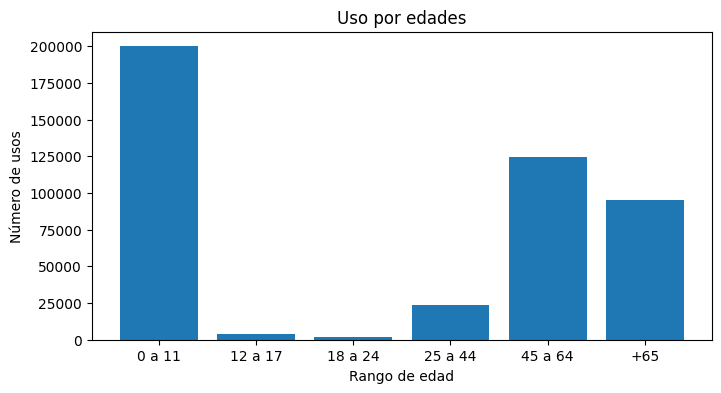

In [33]:
usos_edades = [usos_niños,usos_adolescentes,usos_jovenes,usos_jovenes_adultos,usos_adultos,usos_mayores]
plt.figure(figsize=(8,4))
plt.bar(edades, usos_edades)
plt.ylabel('Número de usos')
plt.xlabel('Rango de edad')
plt.title('Uso por edades')
plt.show()

# Realizamos un histograma del tiempo medio de trayecto por rango de edad, con el fin de visualizarlo graficamente

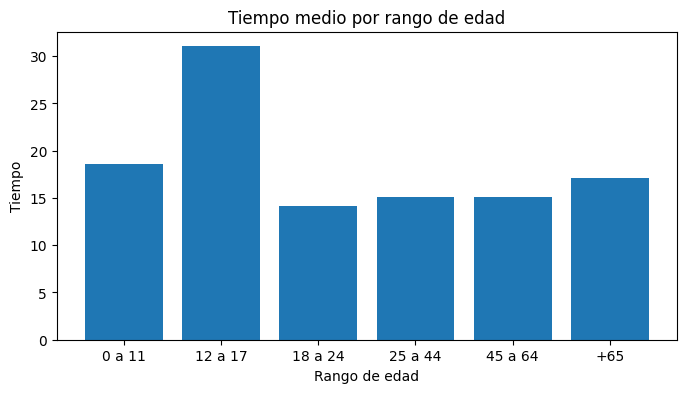

In [34]:
media_edades = [media_niños,media_adolescentes,media_jovenes,media_jovenes_adultos,media_adultos,media_mayores]
plt.figure(figsize=(8,4))
plt.bar(edades, media_edades)
plt.ylabel('Tiempo')
plt.xlabel('Rango de edad')
plt.title('Tiempo medio por rango de edad')
plt.show()